# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [6]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.7 MB/s eta 0:00:00


In [84]:
import torch
import numpy as np
from dataset import TextDataset

In [85]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', max_length=512)

In [86]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [92]:
from model import LanguageModel

In [93]:
model = LanguageModel(train_set)

In [94]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

In [95]:
from torch import optim
from torch import nn
from train import train
from torch.utils.data import DataLoader

In [96]:
num_epochs = 20
batch_size = 128

In [61]:
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [97]:
rnn_model = LanguageModel(train_set).to(device)
rnn_optimizer = optim.AdamW(rnn_model.parameters(), lr=1e-3)
rnn_scheduler = optim.lr_scheduler.CosineAnnealingLR(rnn_optimizer, T_max=num_epochs)

In [100]:
train(rnn_model, rnn_optimizer, rnn_scheduler, train_loader, val_loader, num_epochs=num_epochs)

Training 1/20:   0%|          | 0/897 [00:00<?, ?it/s]

RuntimeError: ignored

In [64]:
torch.save(rnn_model.state_dict(), 'rnn.model')
torch.save(rnn_optimizer.state_dict(), 'opt_rnn.model')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [71]:
lstm_model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
lstm_optimizer = optim.AdamW(lstm_model.parameters(), lr=1e-3)
lstm_scheduler = optim.lr_scheduler.CosineAnnealingLR(lstm_optimizer, T_max=num_epochs)

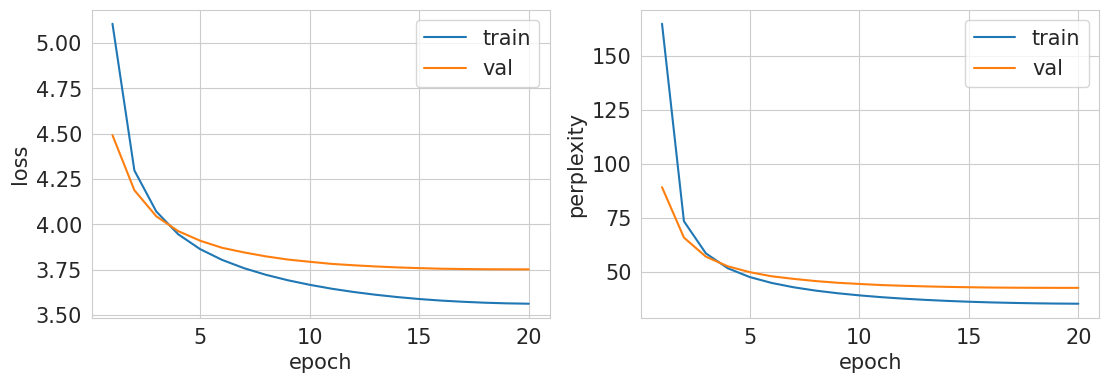

Generation examples after epoch=20:
необпо представля надо обевы придулес хочу об было сижнохопри обма открыразсисислерамепверс первый так исвер бысверсмы разговарипро.собпри направс стоитмести расс понима завдерссрабыхосмес чи лаиз было ду деле имеизск былоопро перефприсслемы мужизслос чапре смофсемсивы уста нравф былочетгодсупримысискосчачавозлепримо любоскосгод в вос успесчетчемприсмопри полкра смот расмы такиепоссверхо имеме покупа запсфиз стоитмер смотсу име име палеприиз былопо хполе работаетмыразсилимемы вопречатпримопрехо такспри простомы мер застрос выхоспо нашелхо сталиму толькооб з сслемымылетс бы размоле пла досста оченьпсобск смотритбемемыс буравгместоясобравосмы длястас спаводоретис потому поссбы однойпри спрашиперефполмымесскоприфприрапоизлебмы стоит стси под в то над мепримы примысме на!мы наде, спемесс прекра толвозсмепрекрамелетавасле подле
тот,,,, о п, ко же, же,,,,, ду,. фа,,,... же же же ва, бы. зна же будет,, да,.,., же.,, же, ку, же же.,,, же,,,...,, же обо же ку

In [72]:
train(lstm_model, lstm_optimizer, lstm_scheduler, train_loader, val_loader, num_epochs=num_epochs)

perplexity примерно получилось одинаковые, а loss у LSTM поменьше

In [73]:
torch.save(lstm_model.state_dict(), 'lstm.model')
torch.save(lstm_optimizer.state_dict(), 'opt_lstm.model')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [77]:
prefixes = ['хохол', 'приходит обама', 'разработчик текила нейросеть']
temps = np.linspace(0.1, 2, 10)

In [78]:
for prefix in prefixes:
  for temp in temps:
    generated = lstm_model.inference(prefix, temp)
    print('----------')
    print('prefix: ', prefix)
    print('temp: ', temp)
    print('RNN: ', rnn_model.inference(prefix, temp))
    print('LSTM: ', lstm_model.inference(prefix, temp))

----------
prefix:  хохол
temp:  0.1
RNN:  хохол в магазиетететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететет
LSTM:  хохол в россииелоенетететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететететет

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [79]:
train_set = TextDataset(data_file='jokes.txt', vocab_size=4000, train=True, sp_model_prefix='bpe4000', max_length=300)
valid_set = TextDataset(data_file='jokes.txt', vocab_size=4000, train=False, sp_model_prefix='bpe4000', max_length=300)


In [80]:
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [81]:
lstm_model_4000 = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
lstm_optimizer_4000 = optim.AdamW(lstm_model_4000.parameters(), lr=1e-3)
lstm_scheduler_4000 = optim.lr_scheduler.CosineAnnealingLR(lstm_optimizer_4000, T_max=num_epochs)

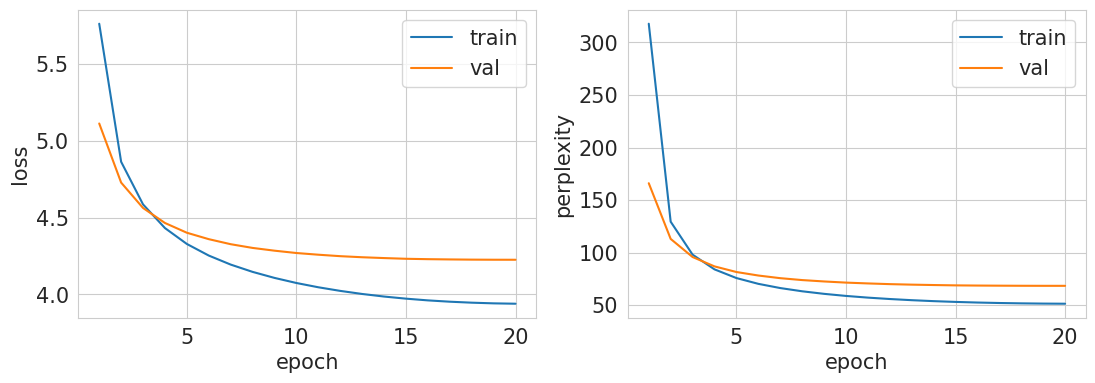

Generation examples after epoch=20:
на работуботциона ча светебо времен кладпавециона выбоморриродеционасовходмо уротураси учесывациона занясоциона вопрослогасовлогзобор мокатказаправморгляционакловаправционазнасов которомционалейзовтехционасовступиционабосиходционабоноционабгобормоционабобо кпе улиступсционаклокрафосызовстрой выбопибострой майха роди треть которыхвило всявасикационагра жузомордесовстве некоторы свялог профе присиционасысиступилзо нашбопационасовпи уромосилисовсивы ваправпротиввепервавосовсовциона цен какомходпро томционаворциона специа некокрабовоционабо крыгре звонокродестройпротив погосовго пи сасбо послед одинмесовтувобоут светеморбовоционаморграционасиливод б турапроводзнагосционаряд чемправмиступиправ запаправ вопрос сколько ста а уровстройреционарядварморкрасовционапростройморвомознаходяционаморправворфиходасоввовозгразна з бавиционазнародеходлеступ ка многоционасорагоходвомационабво .знаборвагреционававопросовтура другойбомокрывозмофепабоционасы прибор дорогист

In [82]:
train(lstm_model_4000, lstm_optimizer_4000, lstm_scheduler_4000, train_loader, val_loader, num_epochs=num_epochs)

In [ ]:
torch.save(lstm_model_4000.state_dict(), 'lstm_4000.model')
torch.save(lstm_optimizer_4000.state_dict(), 'opt_lstm_4000.model')

In [ ]:
train_set = TextDataset(data_file='jokes.txt', vocab_size=4000, model_type='unigram', train=True, sp_model_prefix='unigram4000', max_length=300)
valid_set = TextDataset(data_file='jokes.txt', vocab_size=4000, model_type='unigram', train=False, sp_model_prefix='unigram4000', max_length=300)


In [ ]:
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
lstm_model_unigram4000 = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
lstm_optimizer_unigram4000 = optim.AdamW(lstm_model_unigram4000.parameters(), lr=1e-3)
lstm_scheduler_unigram4000 = optim.lr_scheduler.CosineAnnealingLR(lstm_optimizer_unigram4000, T_max=num_epochs)

In [ ]:
train(lstm_model_unigram4000, lstm_optimizer_unigram4000, lstm_scheduler_unigram4000, train_loader, val_loader, num_epochs=num_epochs)

In [ ]:
torch.save(lstm_model_unigram4000.state_dict(), 'lstm_unigram4000.model')
torch.save(lstm_optimizer_unigram4000.state_dict(), 'opt_lstm_unigram4000.model')

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.